<a href="https://colab.research.google.com/github/RedouaneDziriabd/EmotionRecognition/blob/main/Emotion_Recognition_in_Text_Using_NLP_with_LSTM_and_Transformer_Based_Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Libraries and Transformer Tokenizer**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
transformer_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#**Load Dataset (Train, Validation, Test)**

In [2]:
train_df = pd.read_csv("/content/Redouane/train.txt", sep=";", names=["text", "label"])
val_df = pd.read_csv("/content/Redouane/val.txt", sep=";", names=["text", "label"])
test_df = pd.read_csv("/content/Redouane/test.txt", sep=";", names=["text", "label"])

combined_df = pd.concat([train_df, val_df])

#**List All Emotion Classes in Dataset**

In [3]:
emotion_classes = sorted(train_df['label'].unique().tolist())
print("✅ Classes in the dataset:", emotion_classes)

✅ Classes in the dataset: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


#**Visualize Class Distribution in Dataset**

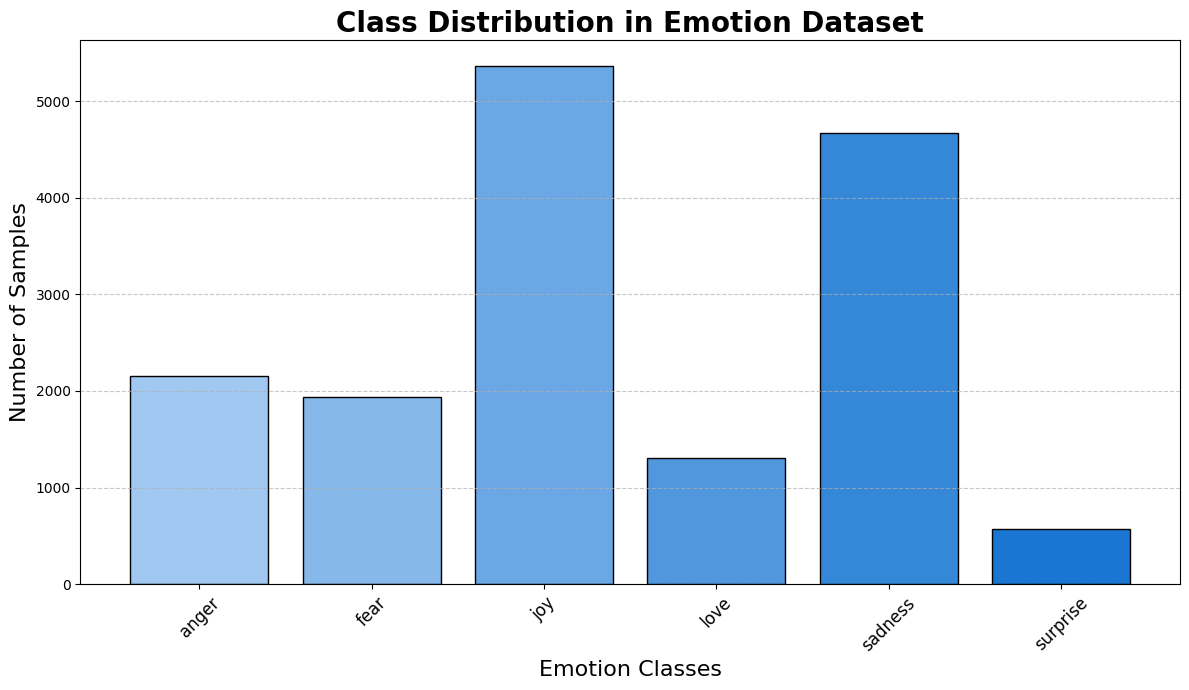

In [4]:
class_counts = train_df['label'].value_counts().sort_index()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("skyblue_gradient", ["#a0c8f0", "#0066cc"])

plt.figure(figsize=(12, 7))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

for i, bar in enumerate(bars):
    bar.set_facecolor(cmap(i / len(bars)))

plt.title('Class Distribution in Emotion Dataset', fontsize=20, fontweight='bold')
plt.xlabel('Emotion Classes', fontsize=16)
plt.ylabel('Number of Samples', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#**Transformer Tokenizer Demonstration (BERT-style)**

In [5]:
text = "I love Generative AI Lesson!"
encoded_text = transformer_tokenizer(text)
print("Encoded:", encoded_text)

tokens = transformer_tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
print("Tokens:", tokens)

Encoded: {'input_ids': [101, 1045, 2293, 11416, 6024, 9932, 10800, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['[CLS]', 'i', 'love', 'genera', '##tive', 'ai', 'lesson', '!', '[SEP]']


#**Tokenize Text Data and Encode Emotion Labels**

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_df['text'])

sequences = tokenizer.texts_to_sequences(combined_df['text'])
max_len = max(len(s) for s in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(combined_df['label'])
labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

#**Build and Compile Bidirectional LSTM Model**

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    padded_sequences, labels_categorical, test_size=0.2, random_state=42
)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#**Train the Model**

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4463 - loss: 1.3949 - val_accuracy: 0.8244 - val_loss: 0.4852
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8946 - loss: 0.3045 - val_accuracy: 0.8903 - val_loss: 0.2931
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9598 - loss: 0.1180 - val_accuracy: 0.9094 - val_loss: 0.2688
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9761 - loss: 0.0717 - val_accuracy: 0.9117 - val_loss: 0.2813
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9843 - loss: 0.0468 - val_accuracy: 0.9067 - val_loss: 0.2977
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9863 - loss: 0.0385 - val_accuracy: 0.9006 - val_loss: 0.3632
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9873 - loss: 0.0344 - val_accuracy: 0.9056 - val_loss: 0.3636
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9878 - loss: 0.0401 - val_a

#**Plot Training vs. Validation Accuracy and Loss**

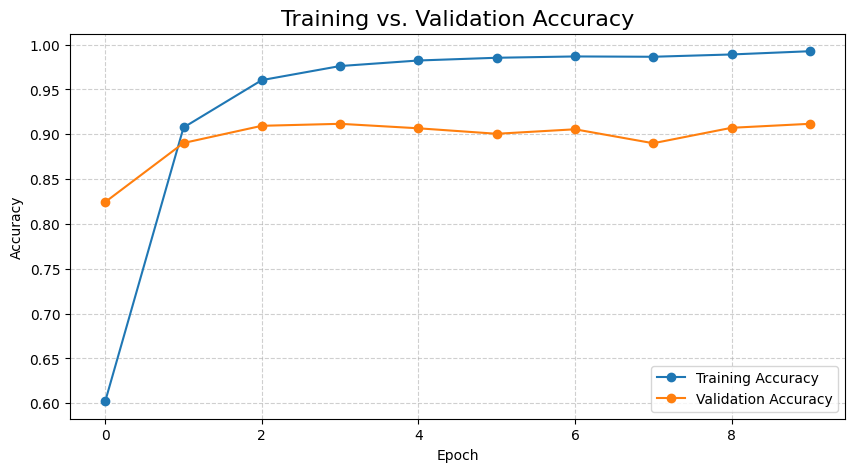

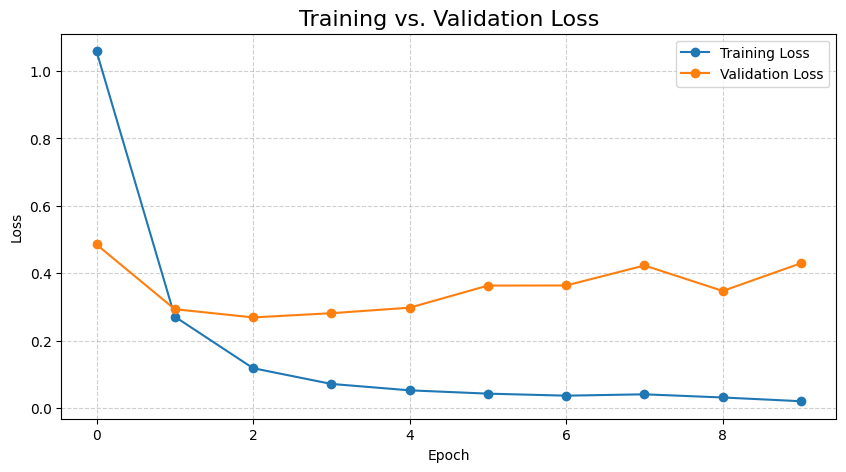

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs. Validation Accuracy', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#**Evaluate Model on Test Dataset**

In [10]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_len)
test_labels = label_encoder.transform(test_df['label'])
test_onehot = tf.keras.utils.to_categorical(test_labels)

loss, accuracy = model.evaluate(test_padded, test_onehot)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9024 - loss: 0.4616
Test Loss: 0.4463
Test Accuracy: 90.35%


#**Show Classification Report and Confusion Matrix**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

       anger       0.90      0.91      0.91       275
        fear       0.88      0.86      0.87       224
         joy       0.89      0.96      0.92       695
        love       0.86      0.64      0.74       159
     sadness       0.96      0.94      0.95       581
    surprise       0.74      0.73      0.73        66

    accuracy                           0.90      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



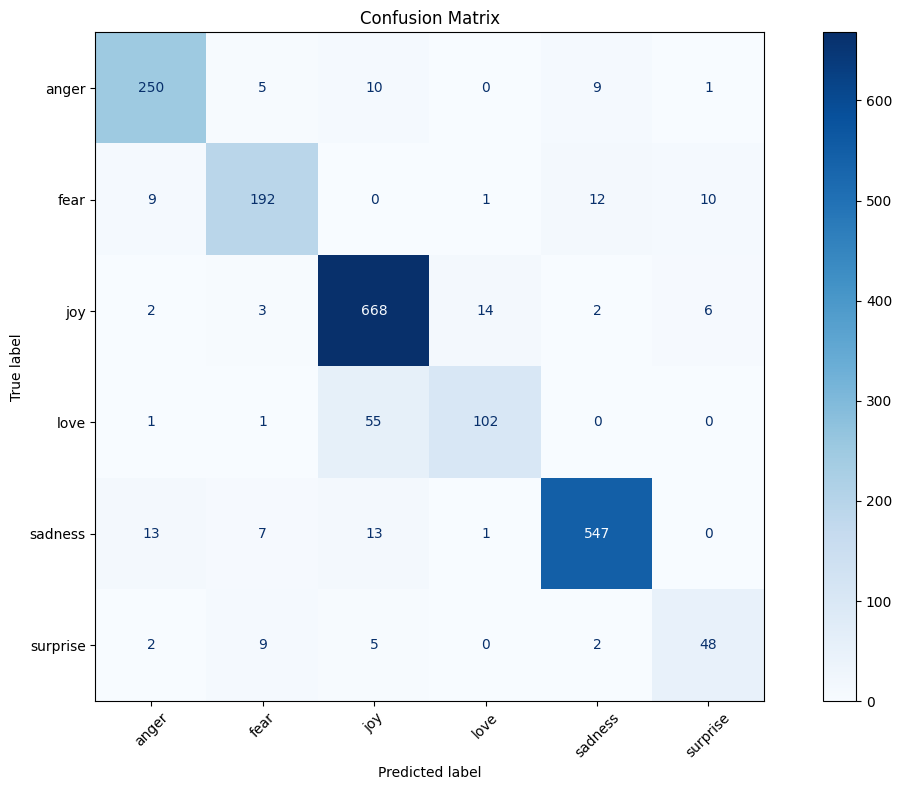

In [11]:
y_pred_probs = model.predict(test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_onehot, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#**Predict Emotions from Sample Sentences and Visualize**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


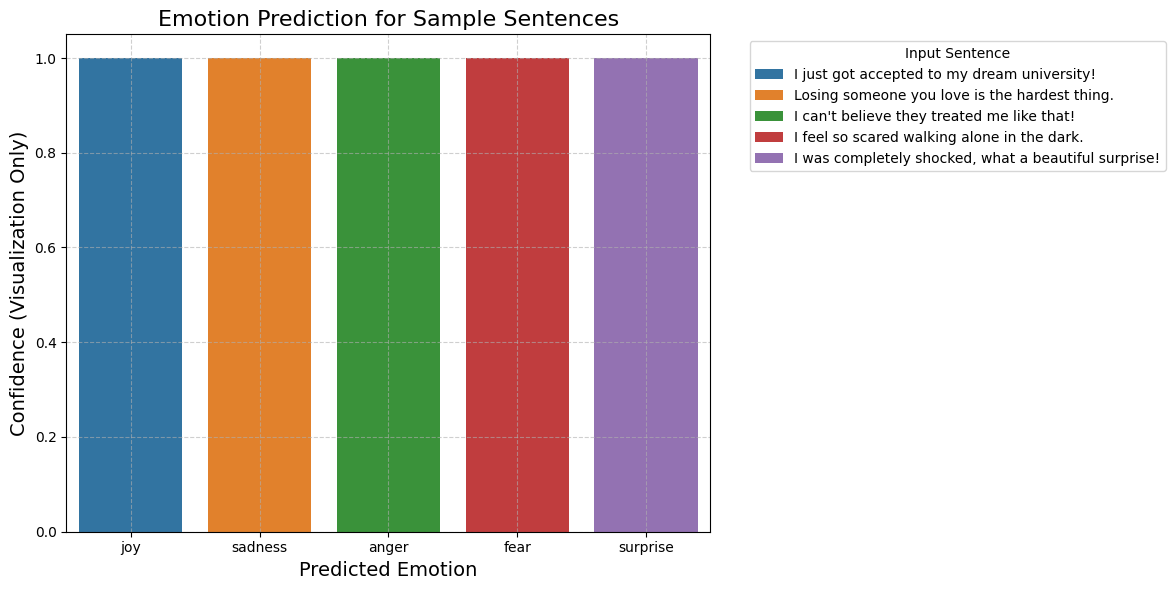

In [12]:
sample_texts = [
    "I just got accepted to my dream university!",
    "Losing someone you love is the hardest thing.",
    "I can't believe they treated me like that!",
    "I feel so scared walking alone in the dark.",
    "I was completely shocked, what a beautiful surprise!"
]

predicted_emotions = []
for text in sample_texts:
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad)
    emotion = label_encoder.inverse_transform([np.argmax(pred)])[0]
    predicted_emotions.append(emotion)

df_results = pd.DataFrame({
    "Input Text": sample_texts,
    "Predicted Emotion": predicted_emotions
})

plt.figure(figsize=(12, 6))
sns.barplot(x="Predicted Emotion", y=[1]*len(predicted_emotions), hue="Input Text", data=df_results, dodge=False)
plt.title("Emotion Prediction for Sample Sentences", fontsize=16)
plt.xlabel("Predicted Emotion", fontsize=14)
plt.ylabel("Confidence (Visualization Only)", fontsize=14)
plt.legend(title="Input Sentence", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()